In [1]:
# ======================
# Preprocesamiento de datos para el dataset 'startup-success-prediction'
# ======================

!pip install kagglehub --quiet

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import StandardScaler

# ======================
# 1. Descarga y carga del dataset original
# ======================
path = kagglehub.dataset_download("manishkc06/startup-success-prediction")
csv_path = os.path.join(path, "startup data.csv")
df = pd.read_csv(csv_path)

# ======================
# 2. Limpieza inicial de columnas irrelevantes
# ======================
initial_drop = [
    'Unnamed: 0', 'Unnamed: 6', 'state_code.1', 'id', 'object_id', 'name'
]
df.drop(columns=[c for c in initial_drop if c in df.columns], inplace=True)

# ======================
# 3. Conversión de columnas de fecha
# ======================
for c in ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']:
    df[c] = pd.to_datetime(df[c], errors='coerce')

# ======================
# 4. Asegurar existencia de la columna 'status'
# ======================
if 'status' not in df.columns:
    raw = pd.read_csv(csv_path, usecols=['status'])
    df['status'] = raw['status']

# ======================
# 5. Creación de variables temporales derivadas
# ======================
fecha_corte = pd.to_datetime("2025-01-01")
df['lifetime_years'] = ((df['closed_at'].fillna(fecha_corte) - df['founded_at']).dt.days / 365).round(2)
df['funding_delay_years'] = ((df['first_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['last_milestone_delay_years'] = ((df['last_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['post_funding_duration_years'] = ((df['closed_at'].fillna(fecha_corte) - df['last_funding_at']).dt.days / 365).round(2)

# ======================
# 6. Eliminación de observaciones con errores temporales
# ======================
mask = (
    (df['lifetime_years'] < 0) |
    (df['funding_delay_years'] < 0) |
    (df['last_milestone_delay_years'] < 0) |
    (df['post_funding_duration_years'] < 0) |
    (df.get('age_first_funding_year', 0) < 0) |
    (df.get('age_last_funding_year', 0) < 0) |
    (df.get('age_first_milestone_year', 0) < 0) |
    (df.get('age_last_milestone_year', 0) < 0)
)
df = df.loc[~mask].copy()

# ======================
# 7. Clasificación sector y agrupación de ciudades
# ======================
tech = {'software', 'web', 'mobile', 'enterprise'}
df['main_sector'] = df['category_code'].apply(lambda x: 'tech' if x in tech else 'non_tech')

top = df['city'].value_counts()
freq = top[top > 20].index
df['city_grouped'] = df['city'].apply(lambda x: x if x in freq else 'other')

# ======================
# 8. Escalado de variables numéricas
# ======================
scaler = StandardScaler()
for col in ['funding_total_usd', 'relationships', 'avg_participants']:
    if col in df.columns:
        df[f"{col}_scaled"] = scaler.fit_transform(df[[col]])

# ======================
# 9. Variables booleanas derivadas
# ======================
df['has_milestones'] = df['milestones'] > 0
df['has_late_funding'] = (df.get('has_roundC', 0) == 1) | (df.get('has_roundD', 0) == 1)

# ======================
# 10. Eliminación de columnas redundantes
# ======================
derived_drop = [
    'city', 'category_code', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',
    'milestones', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
    'funding_total_usd', 'relationships', 'avg_participants'
]

extra_drop = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year',
    'state_code', 'zip_code', 'latitude', 'longitude',
    'has_milestone_info', 'status', 'is_top500'
]

drop_all = derived_drop + extra_drop + [c for c in df.columns if c.startswith('is_')]
df.drop(columns=[c for c in drop_all if c in df.columns], inplace=True)

# ======================
# 11. Separación de variable objetivo
# ======================
X = df.drop(columns='labels')
y = df['labels'].astype(int).values

# ======================
# 12. Resultado final
# ======================
print("Columnas finales disponibles para modelado:", X.columns.tolist())
print("Número de muestras:", X.shape[0])

100%|██████████| 64.1k/64.1k [00:00<00:00, 50.9MB/s]

Extracting files...


Columnas finales disponibles para modelado: ['funding_rounds', 'has_VC', 'has_angel', 'lifetime_years', 'funding_delay_years', 'last_milestone_delay_years', 'post_funding_duration_years', 'main_sector', 'city_grouped', 'funding_total_usd_scaled', 'relationships_scaled', 'avg_participants_scaled', 'has_milestones', 'has_late_funding']
Número de muestras: 825


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejores parámetros encontrados:
  - classifier__criterion: entropy
  - classifier__max_depth: 10
  - classifier__max_features: log2
  - classifier__min_samples_leaf: 2
  - classifier__min_samples_split: 2
  - classifier__n_estimators: 200
Mejor ROC AUC en validación cruzada: 0.9983
OOB score: 0.9924
Accuracy: 98.79%
Classification Report:

              precision    recall  f1-score   support

           0     0.9649    1.0000    0.9821        55
           1     1.0000    0.9818    0.9908       110

    accuracy                         0.9879       165
   macro avg     0.9825    0.9909    0.9865       165
weighted avg     0.9883    0.9879    0.9879       165

ROC AUC: 0.9916



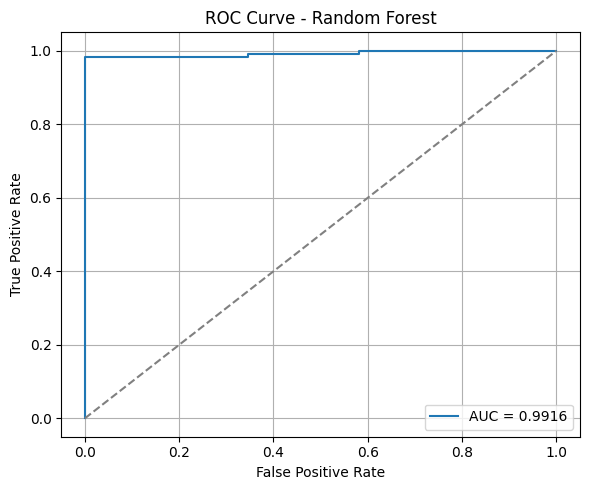

In [2]:
"""
Random Forest es un modelo de predicción que construye un conjunto de árboles de decisión.
Cada árbol se entrena con una muestra aleatoria de los datos de entrenamiento (bootstrap).
En el entrenamiento, para cada árbol, algunas muestras de los datos de entrenamiento no se utilizan para construir ese árbol específico, (muestras out-of-bag).
Se pueden utilizan árboles que no las incluyen en su entrenamiento para hacer una predicción, denominada out-of-bag.



Se importan las siguientes librerías por los siguientes motivos:

pandas: Para manipular y análizar datos,  a través de la estructura DataFrame.
matplotlib.pyplot: Para elaborar gráficos del modelo.
sklearn: Para transformaciones de los dataset.
sklearn.ensemble: Algoritmo de clasificación que se utilizará en el modelo.
sklearn.metrics: Permite medir el rendimiento del modelo, como accuracy_score, classification_report, roc_auc_score y roc_curve.
sklearn.model_selection: Proporciona herramientas para la selección de modelos y la validación, como train_test_split para dividir los datos en conjuntos de entrenamiento y prueba, y GridSearchCV para la búsqueda de hiperparámetros óptimos.
sklearn.pipeline: Permite encadenar diferentes pasos de preprocesamiento y modelado en un único objeto Pipeline.
sklearn.preprocessing: Ofrece métodos para preprocesar los datos antes de aplicar el modelo. En este caso, se importa OneHotEncoder para codificar variables categóricas.
"""


import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#-----

# Se crea función para preparar los datos para el entrenamiento y la evaluación del modelo.

#Se separa el DataFrame df en dos conjuntos, uno con variables predictoras y otro con variable objetivo.
#Se dividen los datos en conjunto de entrenamiento y de prueba. Se hace de manera estratificada para asegurar una distribución de las clases similar.
# El resultado son 4 grupos de variables predictoras y objetivo que son de entrenamiento o de test.
#-----
def preprocesar_datos(df, test_size=0.2, random_state=42):
    """
    Separa el DataFrame en X e y, y realiza
    train/test split estratificado.
    """
    X = df.drop(columns='labels')
    y = df['labels'].astype(int).values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )
    return X_train, X_test, y_train, y_test


# ---
# Se crea un proceso automatizado para simplificar con la función denominada "construir_pipeline" para encadenar transformaciones de datos y un (modelo), que lo hace más robusto.
#---

def construir_pipeline(categorical_features):
    """
    Construye un Pipeline que aplica OneHotEncoder
    a las variables categóricas y luego RandomForest.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'ohe',
                OneHotEncoder(
                    handle_unknown='ignore',
                    sparse_output=False
                ),
                categorical_features
            )
        ],
        remainder='passthrough'
    )

    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced',
        oob_score=True
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', rf),
    ])

    return pipeline

"""
 El modelo RandomForest utiliza los siguientes hiperpámetros, que controlan el modelo y lo obtimizan.
* n_estimators: Número de árboles en el bosque aleatorio. Se prueban valores de 100 y 200.
* max_depth: Profundidad máxima de cada árbol. Se prueban valores de None (sin límite), 10 y 20.
* min_samples_split: Número mínimo de muestras requeridas para dividir un nodo interno. Se prueban valores de 2 y 5.
* min_samples_leaf: Número mínimo de muestras requeridas en un nodo hoja. Se prueban valores de 1 y 2.
* max_features: Número de características a considerar al buscar la mejor división. Se prueban valores de 'sqrt' (raíz cuadrada del número total de características) y 'log2' (logaritmo base 2 del número total de características).
* criterion: Función para medir la calidad de una división. Se prueban valores de 'gini' y 'entropy'.
"""
def ajustar_hiperparametros(pipeline, X_train, y_train):
    """
    Realiza GridSearchCV para encontrar los mejores
    hiperparámetros del Random Forest.
    GridSearchCV evalúa el modelo con todas las combinaciones de hiperparámetros especificadas en param_grid, utilizando validación cruzada con 5 folds (cv=5). Y selecciona combinación, com mejor valor "roc_auc".
    Para cada combinación, se calcula la métrica 'roc_auc' (área bajo la curva ROC), que mide la capacidad del modelo para distinguir entre las clases.
    El área bajo la curva ROC (AUC) es un valor numérico que resume el rendimiento general del modelo de clasificación. Se calcula como el área bajo la curva ROC y varía entre 0 y 1. Si es menor a 0.5 no es mejor que una clasificación aleatoria.
    Un valor de AUC igual a 1 indica que el modelo clasifica perfectamente todos los ejemplos positivos y negativos.

    """
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy'],
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    print("Mejores parámetros encontrados:")
    for param, val in grid_search.best_params_.items():
        print(f"  - {param}: {val}")
    print(f"Mejor ROC AUC en validación cruzada: "
          f"{grid_search.best_score_:.4f}")

    return grid_search.best_estimator_





 """

Se crea función para evaluar el modelo, a partir de tres parámetros que recibe.
Calcula las predicciones del modelo (y_pred) y las probabilidades de las predicciones (y_proba) para el conjunto de prueba.
Se definen las principales métricas de rendimiento precisión (accuracy) y el área bajo la curva ROC (roc_auc).
En el caso de usar  árboles que no incluyen en su entrenamiento una muestra aleatoria de los datos de entrenamientopara hacer una predicción, podemos calcalur el error de predicción utilizando todas las predicciones out-of-bag para las muestras correspondientes,OOB score.
 """
def evaluar_modelo(modelo, X_test, y_test):
    """
    Evalúa el modelo en el conjunto de prueba:
    imprime métricas y dibuja la curva ROC.
    """
    # Predicciones y probabilidades
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Mostrar OOB score si está disponible
    if hasattr(modelo.named_steps['classifier'], 'oob_score_'):
        oob = modelo.named_steps['classifier'].oob_score_
        print(f"OOB score: {oob:.4f}")

    print(f"Accuracy: {accuracy:.2%}")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc:.4f}\n")

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
"""
Código principal para ejecutar funciones anteriores. Del dataframe cargado y limpio.
"""

def main():

    # Cargar o recibir el DataFrame
    # df = pd.read_csv('tu_dataset_limpio.csv')
    # -------------------------------
    # Dividir los datos
    X_train, X_test, y_train, y_test = preprocesar_datos(df)

    # Detectar columnas categóricas
    categorical_features = (
        X_train
        .select_dtypes(include=['object', 'bool', 'category'])
        .columns
        .tolist()
    )

    # Construir pipeline y ajustar hiperparámetros
    pipeline = construir_pipeline(categorical_features)
    mejor_modelo = ajustar_hiperparametros(pipeline, X_train, y_train)

    # Evaluar en test
    evaluar_modelo(mejor_modelo, X_test, y_test)


if __name__ == "__main__":
    main()

Los resultados de este modelo para predecir si una startup tendrá éxito o no genera los siguientes resultados:

1.  Se han probado 96 combinaciones diferentes de parámetros, con una "validación cruzada" con 5 divisiones de los datos, que asegura una evaluación más robusta del modelo.

2. "Los mejores valores de los hiperparámetros del modelo son los siguientes:

* Entropia, como criterio para medir la calidad de una división en el árbol de decisión.
* Máxima profundidad de un arbol de 10 niveles, para prevenir el sobreajuste.
* Número de características a considerar es el logaritmo base 2 del número total de características, y reduce la dimensionalidad del problema y mejorar la eficiencia del modelo.
* número mínimo de muestras que debe haber en un nodo hoja (un nodo terminal del árbol), es 2, es decir,  un nodo se convertirá en hoja si tiene menos de 2 muestras. Preveniene el sobreajuste.
* número mínimo de muestras que debe haber en un nodo para que se considere una división, 2. Un nodo se dividirá solo si tiene al menos 2 muestras. Controla el crecimiento del árbol y a prevenir el sobreajuste.
* Número de árboles de decisión que se utilizan en el bosque aleatorio, 200 árboles, más número mejora el rendimiento del modelo, y aumenta el tiempo de entrenamiento.

3. "ROC AUC en validación cruzada: 0.9983" Excelente resultado cercano al 1 para precedecir a la perfección el resultado.



4. "OOB score: 0.9924" Indica la capacidad del modelo de generalización, e.d., predecir correctamente en datos nuevos.

5. "Accuracy o precisión: 98.79%" o proporción de predicciones correctas sobre el total de predicciones.

6. "Classification Report:"

Precisión: Proporción de predicciones positivas correctas sobre el total de predicciones positivas.
Recall: Proporción de ejemplos positivos correctamente identificados sobre el total de ejemplos positivos reales.
F1-score: Es una medida que combina precisión y recall, proporcionando un balance entre ambos.
Los valores altos en estas métricas indican un buen rendimiento del modelo para ambas clases.

7. "ROC AUC: 0.9916" ahora calculada sobre el conjunto de la prueba.  0.9916 es ligeramente inferior al obtenido en la validación cruzada, pero sigue siendo muy alto, lo que indica un excelente rendimiento del modelo en datos nuevos.

Se puede concluir que el modelo Random Forest tiene un excelente rendimiento en la predicción del éxito de startups, y gran capacidad de generalización y una alta capacidad para distinguir entre las startups exitosas y las no exitosas.

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejores parámetros encontrados:
  - classifier__criterion: entropy
  - classifier__max_depth: 10
  - classifier__max_features: log2
  - classifier__min_samples_leaf: 2
  - classifier__min_samples_split: 2
  - classifier__n_estimators: 200
Mejor ROC AUC en validación cruzada: 0.9983
OOB score: 0.9924
Accuracy: 98.79%
Classification Report:

              precision    recall  f1-score   support

           0     0.9649    1.0000    0.9821        55
           1     1.0000    0.9818    0.9908       110

    accuracy                         0.9879       165
   macro avg     0.9825    0.9909    0.9865       165
weighted avg     0.9883    0.9879    0.9879       165

ROC AUC: 0.9916



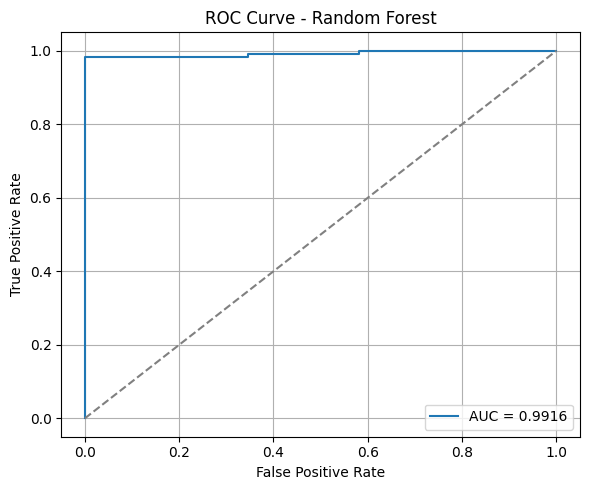

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


def preprocesar_datos(df, test_size=0.2, random_state=42):
    """
    Separa el DataFrame en X e y, y realiza
    train/test split estratificado.
    """
    X = df.drop(columns='labels')
    y = df['labels'].astype(int).values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )
    return X_train, X_test, y_train, y_test


def construir_pipeline(categorical_features):
    """
    Construye un Pipeline que aplica OneHotEncoder
    a las variables categóricas y luego RandomForest.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'ohe',
                OneHotEncoder(
                    handle_unknown='ignore',
                    sparse_output=False
                ),
                categorical_features
            )
        ],
        remainder='passthrough'
    )

    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced',
        oob_score=True
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', rf),
    ])

    return pipeline


def ajustar_hiperparametros(pipeline, X_train, y_train):
    """
    Realiza GridSearchCV para encontrar los mejores
    hiperparámetros del Random Forest.
    """
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy'],
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    print("Mejores parámetros encontrados:")
    for param, val in grid_search.best_params_.items():
        print(f"  - {param}: {val}")
    print(f"Mejor ROC AUC en validación cruzada: "
          f"{grid_search.best_score_:.4f}")

    return grid_search.best_estimator_


def evaluar_modelo(modelo, X_test, y_test):
    """
    Evalúa el modelo en el conjunto de prueba:
    imprime métricas y dibuja la curva ROC.
    """
    # Predicciones y probabilidades
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Mostrar OOB score si está disponible
    if hasattr(modelo.named_steps['classifier'], 'oob_score_'):
        oob = modelo.named_steps['classifier'].oob_score_
        print(f"OOB score: {oob:.4f}")

    print(f"Accuracy: {accuracy:.2%}")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc:.4f}\n")

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def main():
    """
    Punto de entrada principal del script.
    Asume que 'df' es un DataFrame cargado y limpio
    que contiene la columna 'labels'.
    """
    # Cargar o recibir el DataFrame
    # df = pd.read_csv('tu_dataset_limpio.csv')
    # -------------------------------
    # Dividir los datos
    X_train, X_test, y_train, y_test = preprocesar_datos(df)

    # Detectar columnas categóricas
    categorical_features = (
        X_train
        .select_dtypes(include=['object', 'bool', 'category'])
        .columns
        .tolist()
    )

    # Construir pipeline y ajustar hiperparámetros
    pipeline = construir_pipeline(categorical_features)
    mejor_modelo = ajustar_hiperparametros(pipeline, X_train, y_train)

    # Evaluar en test
    evaluar_modelo(mejor_modelo, X_test, y_test)


if __name__ == "__main__":
    main()

Resultados del modelo XGBoost:
Accuracy en test: 0.9878787878787879

Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.9649    1.0000    0.9821        55
           1     1.0000    0.9818    0.9908       110

    accuracy                         0.9879       165
   macro avg     0.9825    0.9909    0.9865       165
weighted avg     0.9883    0.9879    0.9879       165

AUC: 0.9899173553719008


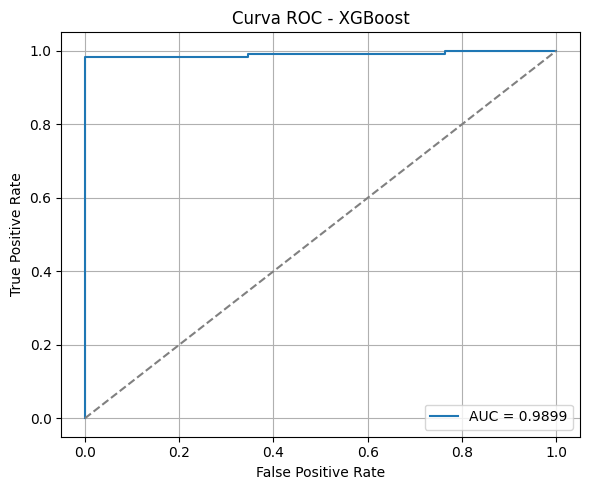

In [7]:
"""
Se descargan bibliotecas, para aplicar el modelo XGBOOST, para evaluar métricas y para visualizar el modelo.
* train_test_split: Para dividir el dataset en conjuntos de entrenamiento y prueba, poder evaluar la capacidad de generalización del modelo, es decir, su rendimiento en datos no vistos durante el entrenamiento.
* ColumnTransformer: Para transformaciones a diferentes subconjuntos de características. *
* Pipeline: Permite automatizar el proceso.
* OneHotEncoder:  Convierte cada categoría en una nueva columna binaria (0 o 1).
* xgboost: Implementa el algoritmo XGBoost (eXtreme Gradient Boosting), que es un método de aprendizaje ensemble basado en árboles de decisión que construye un modelo fuerte combinando múltiples árboles débiles. Tiene alto rendimiento y capacidad para manejar datos complejos.
* Métricas de evaluación:
      accuracy_score: PAra calcular la precisión del modelo.
      classification_report: Para generar informe detallado de precisión, recall, puntuación F1 y soporte para cada clase.
      roc_auc_score: Calcula el área bajo la curva ROC (AUC).
      r oc_curve: Genera los puntos de la curva ROC para visualizar el rendimiento del modelo en diferentes umbrales de clasificación.
*Visualización y manipualción de datos    matplotlib.pyplot, y pandas.
"""
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# A partir del dataset extraido y limpio se procede a aplicar el modelo de XGBOOST

# 1. División del dataset (utilizando la misma división que para TabNet, Random Forest y XGBoost)
X = df.drop(columns='labels')
y = df['labels'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2. Preprocesamiento categórico (igual que para el SVM y Random Forest) Permite se utilicen datos como entrada para el entrenamiento y la predicción
cat_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# 3. Definición del pipeline con XGBoost


"""
Se usa semilla con valor 3 de los mienbros del trabajo. Este métido permite la reproducibilidad, la depuración del código, comparación justa, evitando efecto de la aleatoriedad.
Si el modelo se entrena con una división de datos muy específica, podría no generalizar bien a nuevos datos con una distribución diferente.
Recomendaciones:

Para experimentos iniciales y desarrollo: Usar una semilla fija (como 42, 3, o cualquier otra) es recomendable para la reproducibilidad.
Para evaluar la robustez del modelo: Es buena práctica repetir el experimento con diferentes semillas y observar la variabilidad en los resultados. Esto te dará una idea de la sensibilidad del modelo a la aleatoriedad en la división de los datos.
Para la implementación final: Si el objetivo es obtener el mejor modelo posible sin importar la reproducibilidad exacta, se puede omitir la semilla o usar random_state=None para que la división de los datos sea completamente aleatoria.

"""
pipeline_xgb = Pipeline([
    ('prep', preprocessor),
    ('xgb', xgb.XGBClassifier(random_state=3, eval_metric='logloss'))
])



# 4. Entrenamiento del modelo XGBoost con los datos de entrenamiento.
# El pipeline  aplicar el preprocesamiento necesario antes de pasar los datos al modelo. Una vez que el modelo está entrenado, podemos utilizarlo para realizar predicciones sobre nuevos datos.
pipeline_xgb.fit(X_train, y_train)

# 5. Evaluación y su visualización.
y_pred_xgb = pipeline_xgb.predict(X_test)
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

print("Resultados del modelo XGBoost:")
print("Accuracy en test:", accuracy_score(y_test, y_pred_xgb))
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))

# 6. Curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {roc_auc_score(y_test, y_proba_xgb):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()